In [1]:
from typing import Union, Optional
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pdb

np.set_printoptions(linewidth=160)
np.random.seed(42)

POPULATION_PER_AGE = 1000
MAX_AGE = 50
NUM_YEARS = 50
GLOBAL_DEFAULT_A1 = 10

# Catalytic Model:
## Combination of work from class and extending the model for HW 1

In [2]:
np.append(np.array([1, 0, 2]), 3)

array([1, 0, 2, 3])

In [3]:
class LambdaVariationMethod(Enum):
    """Enum for different methods of varying lambda."""
    YEAR = "year"
    AGE = "age"


def prepare_catalytic_model_config(
    lambda_variation_method: LambdaVariationMethod,
    lambda_variation_params: Union[np.ndarray, list[Union[float, int]]],
    include_births: bool = True,
    deterministic: bool = True,
) -> dict:
    """Prepare the configuration for the simulation."""
    if lambda_variation_method == LambdaVariationMethod.YEAR:
        config = {
            "lambda_variation_method": lambda_variation_method,
            "lambda_variation_params": {
                "lambda_by_year": lambda_variation_params
            },
            "include_births": include_births,
            "deterministic": deterministic,
        }
    elif lambda_variation_method == LambdaVariationMethod.AGE:
        if len(lambda_variation_params) < 2:
            raise ValueError("Not enough parameters provided for lambda variation method.")
        elif len(lambda_variation_params) == 2:
            lambda_variation_params = np.append(lambda_variation_params, GLOBAL_DEFAULT_A1)
        elif len(lambda_variation_params) > 3:
            raise ValueError("Too many parameters provided for lambda variation method.")
        
        config = {
            "lambda_variation_method": lambda_variation_method,
            "lambda_variation_params": {
                "lambda_a": lambda_variation_params[0],
                "lambda_b": lambda_variation_params[1],
                "A_1": lambda_variation_params[2],
            },
            "include_births": include_births,
            "deterministic": deterministic,
        }
    else:
        raise ValueError("Invalid lambda variation method provided. No other variation methods have benen implemented yet.")
    return config


# example_config_by_year = {
#     "lambda_variation_method": LambdaVariationMethod.YEAR,
#     "lambda_variation_params": {
#         "lambda_by_year": np.random.uniform(0.05, 0.15, NUM_YEARS)
#     },
#     "include_births": True,
#     "deterministic": True,
# }
# example_config_by_age = {
#     "lambda_variation_method": LambdaVariationMethod.AGE,
#     "lambda_variation_params": {
#         "lambda_by_age": {
#             "lambda_a": 0.3,
#             "lambda_b": 0.05,
#             "A_1": 10,
#         }
#     },
#     "include_births": True,
#     "deterministic": True,
# }

In [4]:
def catalytic_model(
    config: Optional[dict],
    # lambda_by_year: Optional[np.ndarray] = None,
    # lambda_by_age_params: Optional[list[Union[int, float]]] = None,
    # include_births: bool = True,
    # deterministic: bool = True,
) -> np.ndarray:
    """
    :param lambda_by_year: Infection rate by year
    :param lambda_by_age_params: Infection rate by age
        This is a 1D array of length 3 where the entries are [lambda_a, lambda_b, A_1]
        where lambda(a) = lambda_a if age <= A_1
        and lambda(a) = lambda_b if age > A_1
    :param include_births: Include births in the model
    :param deterministic: If True, use deterministic model

    :return: si_out: Susceptible and Infected by age group and year
    """
    # susceptible and Infected by age group and year
    si_out = np.zeros((NUM_YEARS+1, MAX_AGE+1, 3))

    # Initial first year
    si_out[0, :, 0] = POPULATION_PER_AGE

    if config["include_births"]:
        # 100 Births every year
        si_out[:, 0, 0] = POPULATION_PER_AGE

    if config["lambda_variation_method"] == LambdaVariationMethod.YEAR:
        lambda_by_year = config["lambda_variation_params"]["lambda_by_year"]
        lambda_by_year_and_age = np.repeat(lambda_by_year.reshape(-1, 1), MAX_AGE, axis=1)

    elif config["lambda_variation_method"] == LambdaVariationMethod.AGE:
        lambda_variation_params = config["lambda_variation_params"]
        
        lambda_a = lambda_variation_params["lambda_a"]
        lambda_b = lambda_variation_params["lambda_b"]
        A_1 = (lambda_variation_params["A_1"] + 1).astype(int)

        # pdb.set_trace()

        lambda_by_age = np.zeros(MAX_AGE + 1)
        lambda_by_age[:A_1] = lambda_a
        lambda_by_age[A_1:] = lambda_b

        lambda_by_year_and_age = np.repeat(lambda_by_age.reshape(1, -1), NUM_YEARS, axis=0)

    else:
        raise ValueError("Invalid lambda variation method provided. No other variation methods have been implemented yet.")

    for y_num in range(NUM_YEARS):
        for a_num in range(MAX_AGE):
            curr_susceptible = si_out[y_num, a_num, 0]
            curr_infection = si_out[y_num, a_num, 1]

            curr_lamb = min(lambda_by_year_and_age[y_num, a_num], 1)

            if config["deterministic"]:
                created_infections = curr_susceptible * curr_lamb
            else:
                # TODO: In the future make this a binomial random variable which uses 
                #   this as a probability for each susceptible person to be infected.
                raise NotImplementedError("Stochastic model not implemented yet.")

            new_susceptible = curr_susceptible - created_infections
            new_infection = curr_infection + created_infections

            si_out[y_num + 1, a_num + 1, 0] = new_susceptible
            si_out[y_num + 1, a_num + 1, 1] = new_infection
            si_out[y_num, a_num, 2] = created_infections

    return si_out


def get_infections_by_year(
    si_out: np.ndarray,
) -> np.ndarray:
    """
    Get infections by year from the output of the catalytic model.

    :param si_out: Output of the catalytic model

    :return: Infections by year
    """
    return si_out[:NUM_YEARS, :MAX_AGE, 2].sum(axis=1)


def sum_squared_error(
    ground_truth: np.ndarray,
    best_guess: np.ndarray,
) -> float:
    return ((ground_truth - best_guess)**2).sum()


def objective_function(
    learned_params: np.ndarray,
    lambda_variation_method: LambdaVariationMethod,
    si_out_gt: np.ndarray,
    include_births: bool = True,
    deterministic: bool = True,
    population_wide_error: bool = True,
) -> float:
    """
    Objective function for optimization.

    :param learned_params: Parameters to be optimized various forces of infection
    :param lambda_variation_method: Method of varying lambda either AGE or YEAR for now
    :param infections_by_year_gt: Ground truth infections by year
    :param include_births: Include births in the model
    :param deterministic: If True, use deterministic model

    :return: Sum of squared errors between ground truth and guessed infections
    """
    config = prepare_catalytic_model_config(
        lambda_variation_method=lambda_variation_method,
        lambda_variation_params=learned_params,
        include_births=include_births,
        deterministic=deterministic,
    )
    si_out = catalytic_model(config)

    if population_wide_error:
        infections_guess = get_infections_by_year(si_out)
        infections_gt = get_infections_by_year(si_out_gt)
    
    else:
        infections_guess = si_out[:NUM_YEARS, :MAX_AGE, 2]
        infections_gt = si_out_gt[:NUM_YEARS, :MAX_AGE, 2]
    
    return sum_squared_error(infections_gt, infections_guess)

In [5]:
lambda_by_year_gt = np.random.uniform(0.05, 0.15, NUM_YEARS)
config_gt = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.YEAR,
    lambda_variation_params=lambda_by_year_gt,
)
si_out_gt = catalytic_model(config_gt)

In [6]:
initial_guess = np.random.uniform(0.05, 0.15, NUM_YEARS)
config_guess = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.YEAR,
    lambda_variation_params=initial_guess,
)
si_out_guess = catalytic_model(config_guess)

In [7]:
results_nm = minimize(
    objective_function,
    x0=initial_guess,
    args=(LambdaVariationMethod.YEAR, si_out_gt,),
    method="Nelder-Mead",
    options={"maxiter": 1000},
)

results_bfgs = minimize(
    objective_function,
    x0=np.ones(NUM_YEARS) * 0.1,
    args=(LambdaVariationMethod.YEAR, si_out_gt,),
    method="L-BFGS-B",
    bounds=[(0.01, 0.25)] * NUM_YEARS,
    options={"maxiter": 100},
)

In [8]:
config_nm = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.YEAR,
    lambda_variation_params=results_nm.x,
)
config_bfgs = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.YEAR,
    lambda_variation_params=results_bfgs.x,
)
nm_lambda_si_out = catalytic_model(config_nm)
bfgs_lambda_si_out = catalytic_model(config_bfgs)

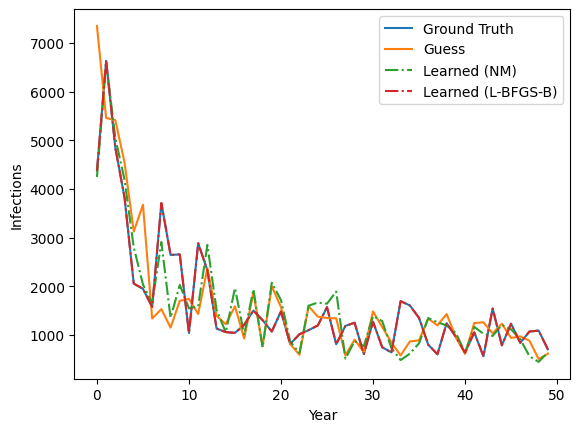

In [9]:
plt.plot(get_infections_by_year(si_out_gt), label="Ground Truth")
plt.plot(get_infections_by_year(si_out_guess), label="Guess")
plt.plot(get_infections_by_year(nm_lambda_si_out), '-.', label="Learned (NM)")
plt.plot(get_infections_by_year(bfgs_lambda_si_out), '-.', label="Learned (L-BFGS-B)")
plt.ylabel("Infections")
plt.xlabel("Year")
plt.legend()
plt.show()

## Variations HW 1

### i) ii) iii) iv)

In [10]:
def plot_infections_by_age_cohort(
    si_out: np.ndarray,
    ages: list[int],
    is_ground_truth: bool = True,
    fig: Optional[plt.Figure] = None,
    axs: Optional[np.ndarray] = None,
) -> None:
    """
    Plot the infections by age cohort.

    :param si_out: Susceptible and Infected by age group and year
    :param ages: List of ages to plot
    :param is_ground_truth: If True, plot the ground truth
    :param fig: Figure to plot on
    :param axs: Axes to plot on

    :return: fig, axs
    """
    if not fig:
        fig_height = len(ages) * 16 // 4
        fig, axs = plt.subplots(len(ages), 2, figsize=(10, fig_height))

    ax = axs.flat

    if is_ground_truth:
        style = "-"
        label = "Ground Truth"
    else:
        style = "--"
        label = "Learned"
    # label = "Ground Truth" if is_ground_truth else "Learned"

    # Turn this is into a forloop where you pass in a value k to get the right diagonal
    for i, age in enumerate(ages):
        susceptible_starting_at_age = np.diag(si_out[:, :, 0], k=age)
        infections_starting_at_age = np.diag(si_out[:, :, 1], k=age)

        ax[i*2].plot(infections_starting_at_age[:-1], label=label, linestyle=style)
        ax[i*2].set_title(f"New Infections\n(Cohort starting at age {age + 1})")
        ax[i*2].set_xlabel("Year of Study (up to 50 years)")
        ax[i*2].legend()
        
        ax[i*2 + 1].plot(susceptible_starting_at_age[:-1]/POPULATION_PER_AGE, label=label, linestyle=style)
        ax[i*2 + 1].set_title(f"Percentage (%) still susceptible\n(Cohort starting at age {age + 1})")
        ax[i*2 + 1].set_xlabel("Year of Study (up to 50 years)")
        ax[i*2 + 1].legend()

    plt.tight_layout()
    
    return fig, axs

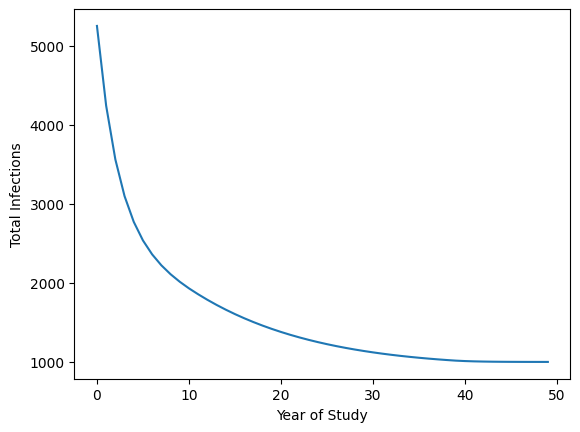

In [11]:
config_foi_by_age_gt = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.AGE,
    lambda_variation_params=np.array([0.3, 0.05, 10]),
)
si_out_foi_by_age_gt = catalytic_model(config_foi_by_age_gt)

plt.plot(get_infections_by_year(si_out_foi_by_age_gt))
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.show()

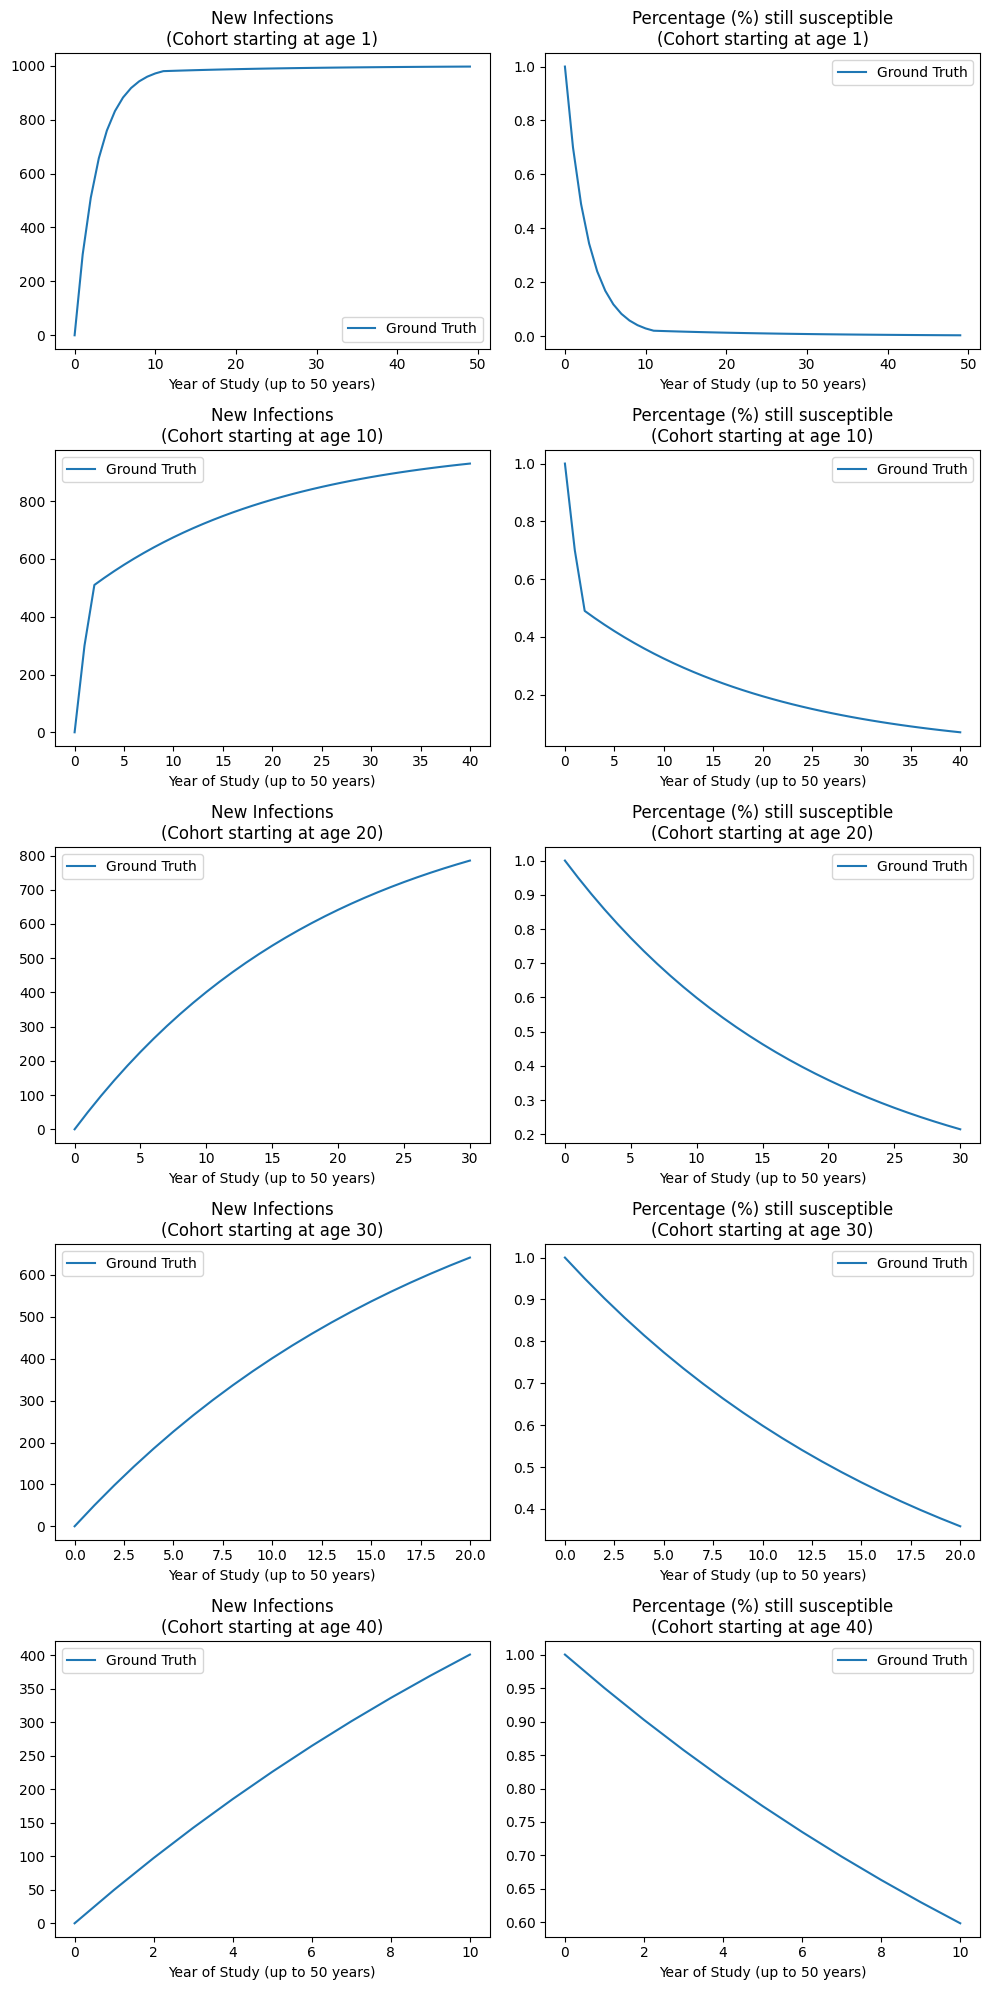

In [12]:
fig, axs = plot_infections_by_age_cohort(
    si_out_foi_by_age_gt,
    ages=[0, 9, 19, 29, 39],
)

### v)

In [14]:
results_nm_lambda_by_age_partial = minimize(
    objective_function,
    x0=[0.1, 0.1],
    args=(LambdaVariationMethod.AGE, si_out_foi_by_age_gt, True, True, False),
    method="Nelder-Mead",
    options={"maxiter": 1000},
)
results_bfgs_lambda_by_age_partial = minimize(
    objective_function,
    x0=[0.1, 0.1],
    args=(LambdaVariationMethod.AGE, si_out_foi_by_age_gt, True, True, False),
    method="L-BFGS-B",
    bounds=[(0.01, 0.5), (0.01, 0.5)],
    options={"maxiter": 100},
)
config_bfgs_lambda_by_age_partial = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.AGE,
    lambda_variation_params=np.append(results_bfgs_lambda_by_age_partial.x, 10),
)
si_out_foi_by_age_partial_learned = catalytic_model(config_bfgs_lambda_by_age_partial)

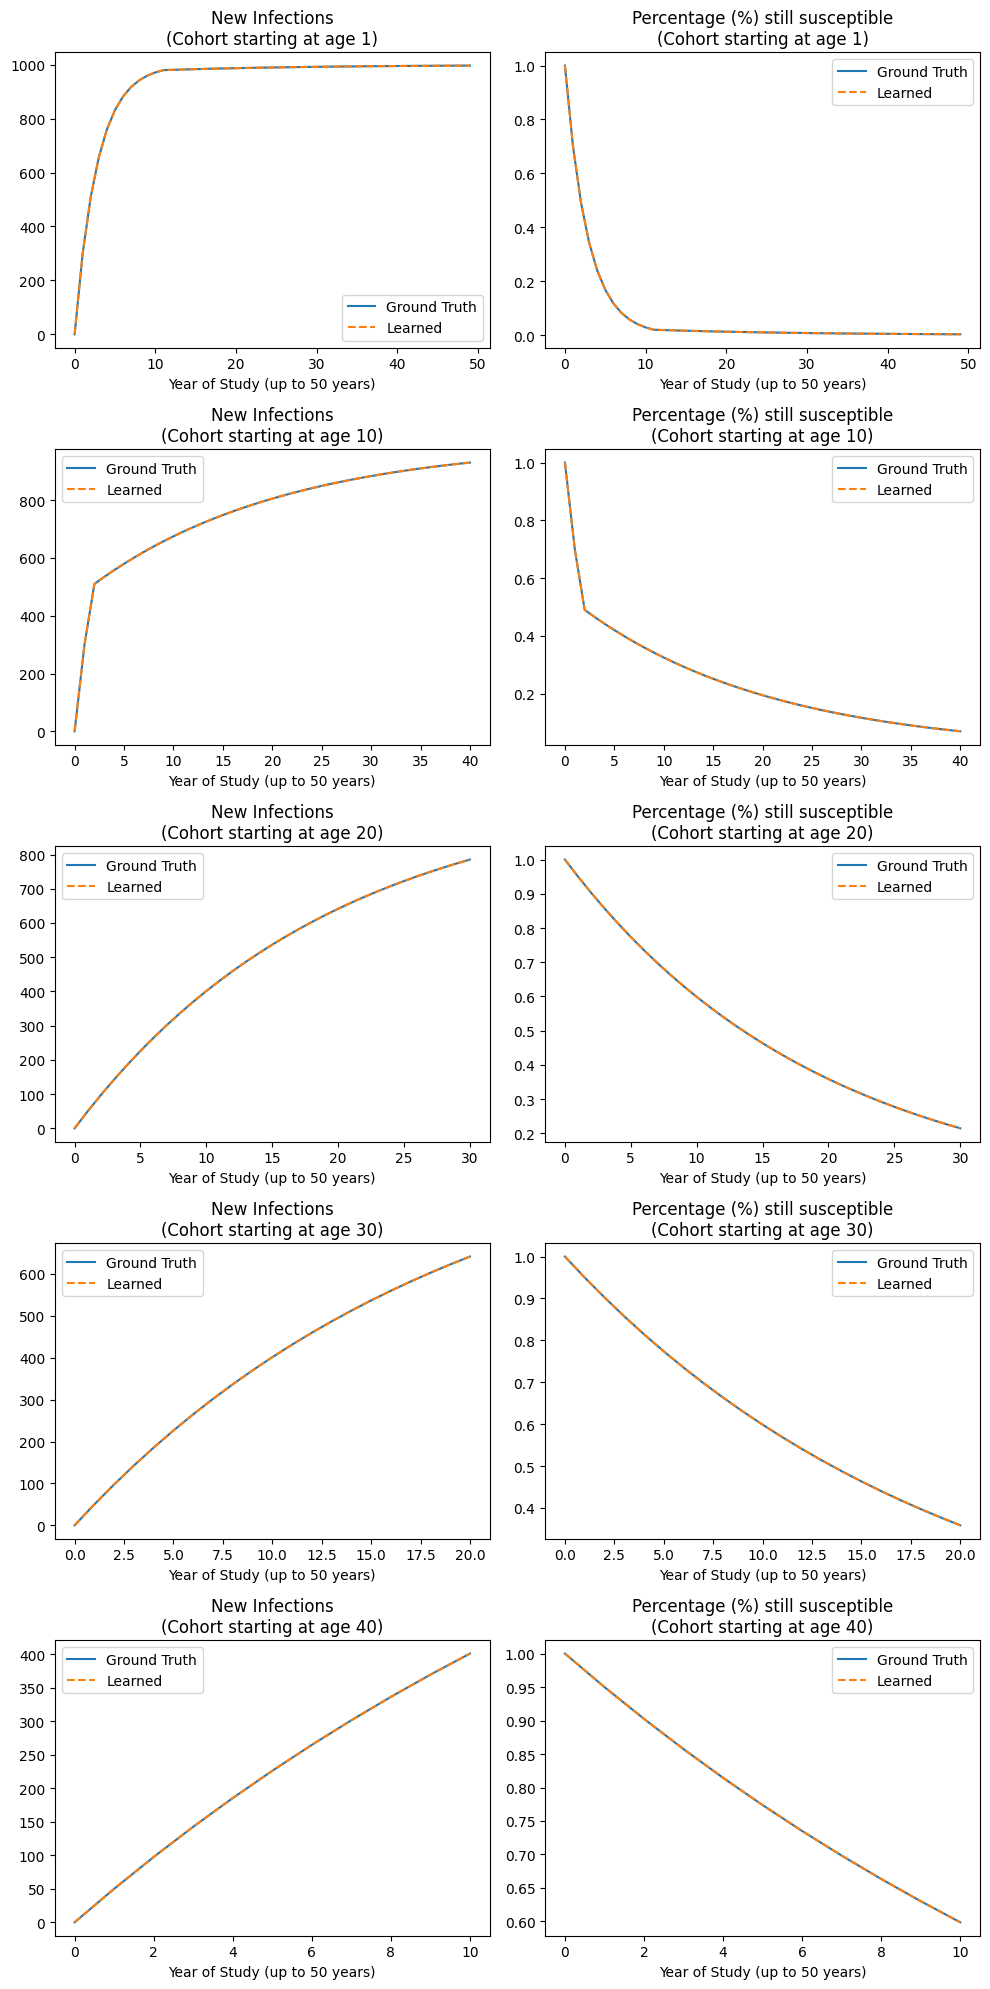

In [15]:
ages = [0, 9, 19, 29, 39]

fig, axs = plot_infections_by_age_cohort(
    si_out_foi_by_age_gt,
    ages=ages,
)
fig, axs = plot_infections_by_age_cohort(
    si_out_foi_by_age_partial_learned,
    ages=ages,
    is_ground_truth=False,
    fig=fig,
    axs=axs,
)
plt.show()

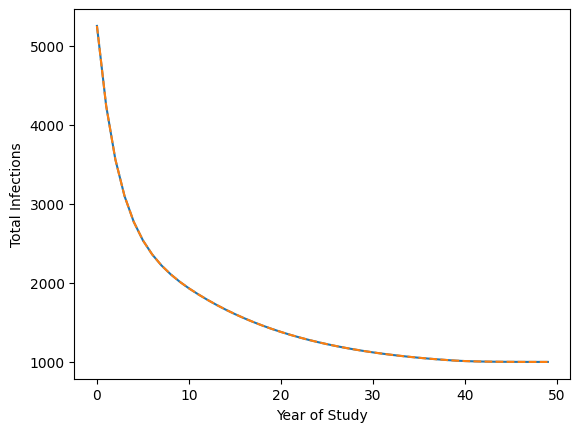

In [16]:
plt.plot(get_infections_by_year(si_out_foi_by_age_gt))
plt.plot(get_infections_by_year(si_out_foi_by_age_partial_learned), linestyle="--")
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.show()

### vi)

In [17]:
results_nm_lambda_by_age_full = minimize(
    objective_function,
    x0=[0.1, 0.1, 5],
    args=(LambdaVariationMethod.AGE, si_out_foi_by_age_gt, True, True, True),
    method="Nelder-Mead",
    options={"maxiter": 1000},
)
results_bfgs_lambda_by_age_full = minimize(
    objective_function,
    x0=[0.1, 0.1, 5],
    args=(LambdaVariationMethod.AGE, si_out_foi_by_age_gt, True, True, True),
    method="L-BFGS-B",
    bounds=[(0.01, 0.5), (0.01, 0.5), (0, 50)],
    options={"maxiter": 100},
)

In [18]:
config_bfgs_lambda_by_age_full = prepare_catalytic_model_config(
    lambda_variation_method=LambdaVariationMethod.AGE,
    lambda_variation_params=results_bfgs_lambda_by_age_full.x,
)
si_out_foi_by_age_full_learned = catalytic_model(config_bfgs_lambda_by_age_full)

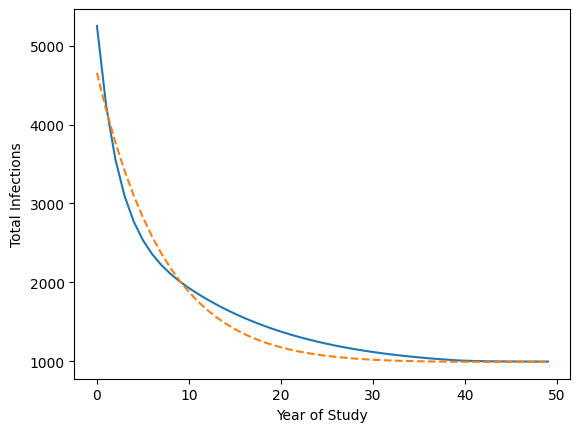

In [19]:
plt.plot(get_infections_by_year(si_out_foi_by_age_gt))
plt.plot(get_infections_by_year(si_out_foi_by_age_full_learned), linestyle="--")
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.show()

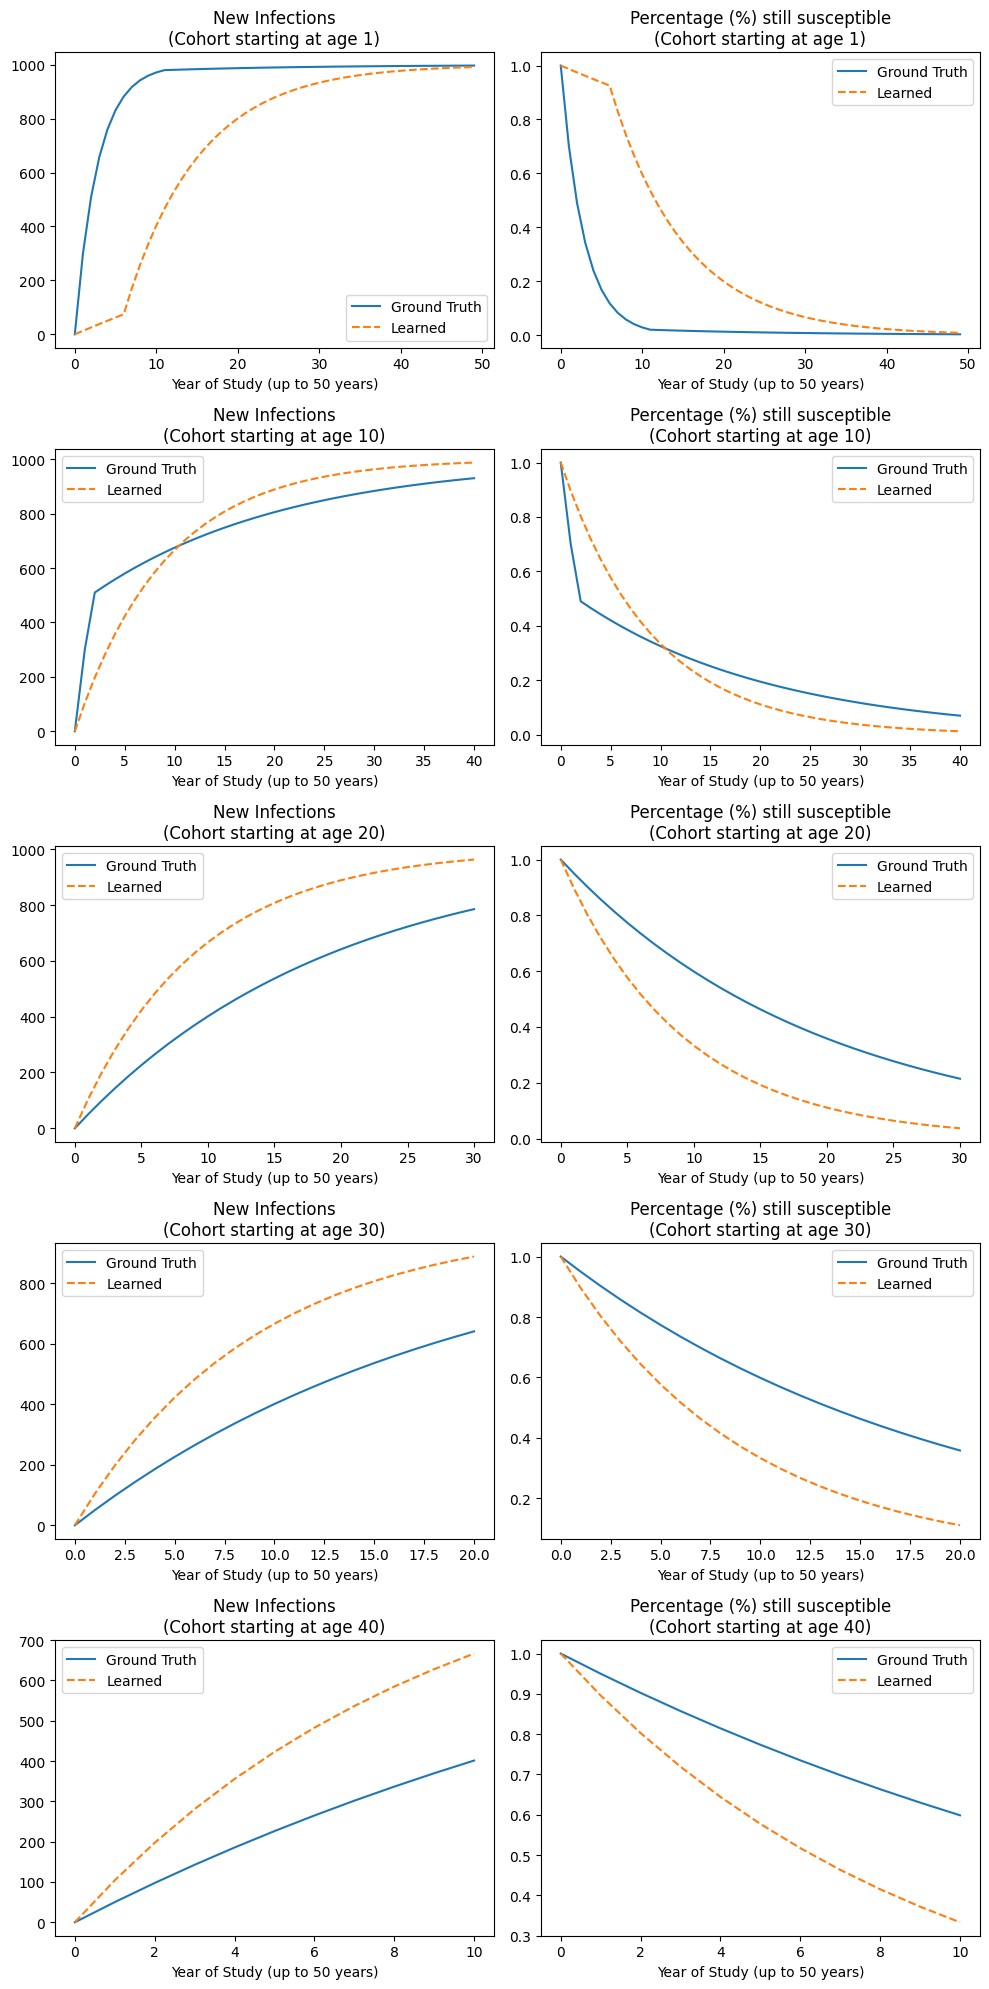

In [20]:
fig, axs = plot_infections_by_age_cohort(
    si_out_foi_by_age_gt,
    ages=ages,
)
fig, axs = plot_infections_by_age_cohort(
    si_out_foi_by_age_full_learned,
    ages=ages,
    is_ground_truth=False,
    fig=fig,
    axs=axs,
)
plt.show()